In [1]:
# Parameters (overridden during execution)
EPOCHS = 30
RUN_ID = 1
OUT_DIR = "/kaggle/working/outputs"

In [2]:
!pip install torchinfo
!pip install --quiet torchview graphviz

In [3]:
import os
import math
import time
import random
import multiprocessing
from datetime import timedelta
from pathlib import Path
from collections import defaultdict
from concurrent.futures import ThreadPoolExecutor
from glob import glob

import numpy as np
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt
from tqdm import tqdm
from IPython.display import SVG, display

from sklearn.metrics import (
    accuracy_score,
    classification_report,
    confusion_matrix,
    f1_score,
    matthews_corrcoef,
    precision_score,
    recall_score,
    roc_auc_score,
)
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torchvision.models import mobilenet_v2, MobileNet_V2_Weights

from timm.models.vision_transformer import VisionTransformer
from torchinfo import summary
from torchview import draw_graph

/usr/local/lib/python3.12/dist-packages/pydantic/_internal/_generate_schema.py:2249: UnsupportedFieldAttributeWarning: The 'repr' attribute with value False was provided to the `Field()` function, which has no effect in the context it was used. 'repr' is field-specific metadata, and can only be attached to a model field using `Annotated` metadata or by assignment. This may have happened because an `Annotated` type alias using the `type` statement was used, or if the `Field()` function was attached to a single member of a union type.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/pydantic/_internal/_generate_schema.py:2249: UnsupportedFieldAttributeWarning: The 'frozen' attribute with value True was provided to the `Field()` function, which has no effect in the context it was used. 'frozen' is field-specific metadata, and can only be attached to a model field using `Annotated` metadata or by assignment. This may have happened because an `Annotated` type alias using the `type` 

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [5]:
from torchvision import datasets, transforms
from torch.utils.data import random_split

In [6]:
# -----------------------------
# Config
# -----------------------------
DATA_DIR = "/kaggle/input"
IMG_SIZE = 224
BATCH_SIZE = 8
NUM_WORKERS = 4
VAL_SPLIT = 0.1
SEED = 42

# -----------------------------
# Base transform (no normalize)
# -----------------------------
base_transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor()
])

# -----------------------------
# Load full training set (stats + split)
# -----------------------------
full_train_dataset = datasets.ImageFolder(
    root=f"{DATA_DIR}/train",
    transform=base_transform
)

In [7]:
# -----------------------------
# Compute mean & std (optimal + tqdm)
# -----------------------------
def compute_mean_std(dataset):
    loader = DataLoader(
        dataset,
        batch_size=BATCH_SIZE,
        shuffle=False,
        num_workers=NUM_WORKERS
    )

    channel_sum = torch.zeros(3)
    channel_sum_sq = torch.zeros(3)
    n_pixels = 0

    for images, _ in tqdm(loader, desc="Computing mean/std", unit="batch"):
        b, c, h, w = images.shape
        pixels = b * h * w

        channel_sum += images.sum(dim=[0, 2, 3])
        channel_sum_sq += (images ** 2).sum(dim=[0, 2, 3])
        n_pixels += pixels

    mean = channel_sum / n_pixels
    std = (channel_sum_sq / n_pixels - mean ** 2).sqrt()
    return mean, std

mean, std = compute_mean_std(full_train_dataset)

Computing mean/std: 100%|██████████| 2157/2157 [00:46<00:00, 46.62batch/s]


In [8]:
# -----------------------------
# Final transform (shared everywhere)
# -----------------------------
final_transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean.tolist(), std.tolist())
])

# -----------------------------
# Rebuild datasets with final transforms
# -----------------------------
full_train_dataset = datasets.ImageFolder(
    root=f"{DATA_DIR}/train",
    transform=final_transform
)

test_dataset = datasets.ImageFolder(
    root=f"{DATA_DIR}/test",
    transform=final_transform
)

# -----------------------------
# Train / Validation split
# -----------------------------
val_size = int(len(full_train_dataset) * VAL_SPLIT)
train_size = len(full_train_dataset) - val_size

generator = torch.Generator().manual_seed(SEED)

train_dataset, val_dataset = random_split(
    full_train_dataset,
    [train_size, val_size],
    generator=generator
)

# Validation must not use augmentation
val_dataset.dataset.transform = final_transform

In [9]:
# -----------------------------
# DataLoaders
# -----------------------------
train_loader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=NUM_WORKERS,
    pin_memory=True
)

val_loader = DataLoader(
    val_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=NUM_WORKERS,
    pin_memory=True
)

test_loader = DataLoader(
    test_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=NUM_WORKERS,
    pin_memory=True
)

# -----------------------------
# Sanity checks
# -----------------------------
print("Classes:", full_train_dataset.classes)
print("Train samples:", len(train_dataset))
print("Val samples:", len(val_dataset))
print("Test samples:", len(test_dataset))

Classes: ['Bacterial Pneumonia', 'COVID', 'Lung_Opacity', 'Normal', 'Tuberculosis', 'Viral Pneumonia']
Train samples: 15526
Val samples: 1725
Test samples: 4929


In [10]:
class CNN_ViT_Model(nn.Module):
    def __init__(self, num_classes):
        super().__init__()

        # Load pretrained MobileNetV2
        pretrained_model = mobilenet_v2(weights=MobileNet_V2_Weights.DEFAULT)
        num_blocks1 = len(pretrained_model.features)

        # Freeze first half of MobileNetV2 efficiently
        for param in pretrained_model.features[:num_blocks1 // 2].parameters():
            param.requires_grad = False

        # Split MobileNetV2 into blocks
        self.mobilenet_feature_blocks_1 = nn.Sequential(*pretrained_model.features[:num_blocks1 - 3])
        self.mobilenet_block_2nd_last = pretrained_model.features[num_blocks1 - 3]
        self.mobilenet_block_mid = pretrained_model.features[num_blocks1 - 2]
        self.mobilenet_block_last = pretrained_model.features[num_blocks1 - 1]

        # Output channel sizes
        ch_2nd_last = self.mobilenet_block_2nd_last.out_channels # 160
        ch_last = self.mobilenet_block_last.out_channels # 1280
        ch_mid = self.mobilenet_block_mid.out_channels # 320
        ch_concat = ch_last + ch_2nd_last # 1440
        
        # CNN to ViT adapter
        adapter_layers = [
            nn.Conv2d(ch_mid, 64, kernel_size=3, padding=1), nn.BatchNorm2d(64), nn.ReLU(inplace=True),
            nn.Upsample(size=(14, 14), mode="bilinear", align_corners=False),
            nn.Conv2d(64, 32, kernel_size=3, padding=1), nn.BatchNorm2d(32), nn.ReLU(inplace=True),
            nn.Upsample(size=(28, 28), mode="bilinear", align_corners=False),
            nn.Conv2d(32, 16, kernel_size=3, padding=1), nn.BatchNorm2d(16), nn.GELU(),
            nn.Upsample(size=(56, 56), mode="bilinear", align_corners=False),
        ]

        self.cnn_to_vit_adapter = nn.Sequential(*adapter_layers)

        # Vision Transformers
        self.vit_encoder1 = VisionTransformer(
            img_size=56, patch_size=7, in_chans=16,
            num_classes=0, embed_dim=64,
            depth=2, num_heads=4, mlp_ratio=2,
            qkv_bias=True, norm_layer=nn.LayerNorm,
        )
        self.vit_encoder1.head = nn.Identity()

        self.vit_encoder2 = VisionTransformer(
            img_size=28, patch_size=7, in_chans=32,
            num_classes=0, embed_dim=64,
            depth=2, num_heads=4, mlp_ratio=2,
            qkv_bias=True, norm_layer=nn.LayerNorm,
        )
        self.vit_encoder2.head = nn.Identity()

        # CNN parallel head (from features_last only)
        self.cnn_parallel_head = nn.Sequential(
            nn.Conv2d(ch_concat, 128, kernel_size=1), nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, kernel_size=3, padding=0), nn.BatchNorm2d(128), nn.ReLU(inplace=True),
            nn.AdaptiveAvgPool2d(1), nn.Flatten(),
        )
        '''
        # 6) Parallel on 4th-last features
        self.parallel2 = nn.Sequential(
            nn.ConvTranspose2d(
                in_channels=ch_mid,
                out_channels=ch_mid,
                kernel_size=3, stride=1, padding=0
            ),
            MaxAvgPool2d(pool_size=(3,3), stride=(1,1)),
            nn.Conv2d(ch_mid * 2, 64, 3, padding=0), nn.BatchNorm2d(64), nn.GELU(),
            nn.Conv2d(64, 8, 3, padding=0), nn.BatchNorm2d(8), nn.ReLU(inplace=True),
            nn.AdaptiveAvgPool2d(1), nn.Flatten(),
        )
        '''
        # Final classifier
        self.classifier_head = nn.Linear(64 + 64 + 128, num_classes)

    def forward(self, x):
        features_1 = self.mobilenet_feature_blocks_1(x)
        features_2nd_last = self.mobilenet_block_2nd_last(features_1)
        features_mid = self.mobilenet_block_mid(features_2nd_last)
        features_last = self.mobilenet_block_last(features_mid)

        # Always resize to match before concat
        concatenated_cnn_features = torch.cat([features_last, features_2nd_last], dim=1)

        x = features_mid
        intermediate = None
        
        for i, layer in enumerate(self.cnn_to_vit_adapter):
            x = layer(x)
        
            # capture second-last stage (before last 4 layers)
            if i == len(self.cnn_to_vit_adapter) - 5:
                intermediate = x
        
        vit_input1 = x                 # full adapter output
        vit_input2 = intermediate      # derived from vit_input1 path
        
        vit_features1 = self.vit_encoder1(vit_input1) # 64
        vit_features2 = self.vit_encoder2(vit_input2) # 32
                
        # CNN parallel branch from final MobileNet block
        cnn_features = self.cnn_parallel_head(concatenated_cnn_features) # 96
        # cnn_features_2 = self.parallel2(features_mid)   # [B, 64]

        # Concatenate and classify
        combined = torch.cat([vit_features1, vit_features2, cnn_features], dim=1)
        return self.classifier_head(combined)

In [11]:
model = CNN_ViT_Model(num_classes=6)
summary(model, input_size=(1, 3, 224, 224),
        col_names=["input_size", "output_size", "num_params", "trainable"])

Downloading: "https://download.pytorch.org/models/mobilenet_v2-7ebf99e0.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v2-7ebf99e0.pth


100%|██████████| 13.6M/13.6M [00:00<00:00, 139MB/s]


Layer (type:depth-idx)                             Input Shape               Output Shape              Param #                   Trainable
CNN_ViT_Model                                      [1, 3, 224, 224]          [1, 6]                    --                        Partial
├─Sequential: 1-1                                  [1, 3, 224, 224]          [1, 160, 7, 7]            --                        Partial
│    └─Conv2dNormActivation: 2-1                   [1, 3, 224, 224]          [1, 32, 112, 112]         --                        False
│    │    └─Conv2d: 3-1                            [1, 3, 224, 224]          [1, 32, 112, 112]         (864)                     False
│    │    └─BatchNorm2d: 3-2                       [1, 32, 112, 112]         [1, 32, 112, 112]         (64)                      False
│    │    └─ReLU6: 3-3                             [1, 32, 112, 112]         [1, 32, 112, 112]         --                        --
│    └─InvertedResidual: 2-2                      

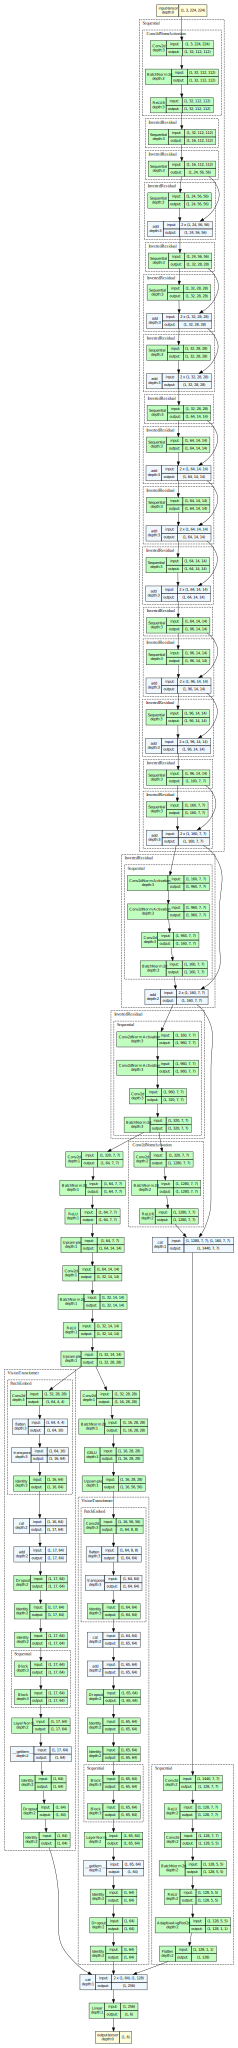

In [12]:
model.to(device)

# Dummy input (can adjust shape based on your model's expected input)
dummy_input = torch.randn(1, 3, 224, 224, device=device)

# Generate the graph — expand_nested=True if model has nested submodules
model_graph = draw_graph(
    model,
    input_data=dummy_input,
    expand_nested=True,
    graph_name="CNN_ViT_Model",
    save_graph=False  # We don't want to save, only display inline
)

# Render to SVG and display inline in the notebook
svg_output = model_graph.visual_graph.pipe(format='svg')
display(SVG(svg_output))

In [13]:
def custom_metrics(y_pred, y_true, loss):
    y_pred_classes = torch.argmax(y_pred, dim=1)

    y_true_numpy = y_true.cpu().numpy()
    y_pred_classes_numpy = y_pred_classes.cpu().numpy()
    accuracy = accuracy_score(y_true_numpy, y_pred_classes_numpy)

    precision = precision_score(y_true_numpy, y_pred_classes_numpy, average='weighted', zero_division=0)
    recall = recall_score(y_true_numpy, y_pred_classes_numpy, average='weighted', zero_division=0)
    f1 = f1_score(y_true_numpy, y_pred_classes_numpy, average='weighted', zero_division=0)

    cm = confusion_matrix(y_true_numpy, y_pred_classes_numpy)

    tn = cm[0, 0]
    fp = cm[0, 1:].sum()
    fn = cm[1:, 0].sum()
    tp = cm[1:, 1:].sum()

    specificity = tn / (tn + fp) if (tn + fp) != 0 else 0.0
    sensitivity = tp / (tp + fn) if (tp + fn) != 0 else 0.0

    mcc = matthews_corrcoef(y_true_numpy, y_pred_classes_numpy)

    num_classes = y_pred.shape[1]
    auc_scores = []

    for class_idx in range(num_classes):
        class_y_true = (y_true_numpy == class_idx).astype(np.float32)
        class_y_pred = y_pred[:, class_idx].cpu().numpy()

        # Skip AUC if only one class is present
        if np.unique(class_y_true).size < 2:
            continue
        try:
            auc_score = roc_auc_score(class_y_true, class_y_pred)
            auc_scores.append(auc_score)
        except ValueError:
            continue

    auc_avg = np.mean(auc_scores) if auc_scores else 0.0

    metrics = {
        "loss": loss,
        "accuracy": accuracy,
        "precision": precision,
        "recall": recall,
        "f1_score": f1,
        "specificity": specificity,
        "sensitivity": sensitivity,
        "mcc": mcc,
        "auc": auc_avg,
    }

    return metrics

In [14]:
# Hyperparameters
num_epochs       = EPOCHS
initial_lr       = 1e-4
decay_start_epoch = 10
decay_factor     = 0.97

# Criterion, optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=initial_lr)

# Scheduler policy: 1.0 until epoch 11, then 0.98^(epoch - 11)
lr_lambda = lambda epoch: 1.0 if epoch < decay_start_epoch else decay_factor ** (epoch - decay_start_epoch)
scheduler = optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=lr_lambda)

In [15]:
# Metrics initialization
metric_names = ["loss", "accuracy", "precision", "recall", "f1_score",
                "specificity", "sensitivity", "mcc", "auc"]
train_metrics_history = {metric: [] for metric in metric_names}
val_metrics_history = {metric: [] for metric in metric_names}

total_training_time = 0.0
total_validation_time = 0.0

# Training and validation loop
for epoch in range(num_epochs):
    start_time = time.time()

    # Training loop
    model.train()
    total_train_loss = 0.0
    all_train_predictions = []
    all_train_targets = []

    for batch_idx, (data, targets) in enumerate(tqdm(train_loader, desc=f"Training Epoch [{epoch + 1}/{num_epochs}]")):
        data = data.to(device)
        targets = targets.to(device)

        optimizer.zero_grad()
        outputs = model(data)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        total_train_loss += loss.item()
        all_train_predictions.extend(outputs.detach().cpu().numpy())
        all_train_targets.extend(targets.detach().cpu().numpy())

    end_time = time.time()
    epoch_training_time = end_time - start_time
    total_training_time += epoch_training_time

    average_train_loss = total_train_loss / len(train_loader)
    all_train_predictions = np.array(all_train_predictions)
    all_train_targets = np.array(all_train_targets)

    train_metrics = custom_metrics(torch.tensor(all_train_predictions), torch.tensor(all_train_targets), average_train_loss)
    training_metrics_line = "Train Metrics - " + ", ".join([f"{k}: {v:.4f}" for k, v in train_metrics.items()])
    print(training_metrics_line)

    for metric in metric_names:
        train_metrics_history[metric].append(train_metrics[metric])

    # Validation loop
    model.eval()
    total_val_loss = 0.0
    all_val_predictions = []
    all_val_targets = []
    start_val_time = time.time()

    with torch.no_grad():
        for batch_idx, (data, targets) in enumerate(tqdm(val_loader, desc="Validating Model")):
            data = data.to(device)
            targets = targets.to(device)

            outputs = model(data)
            loss = criterion(outputs, targets)
            total_val_loss += loss.item()

            all_val_predictions.extend(outputs.detach().cpu().numpy())
            all_val_targets.extend(targets.detach().cpu().numpy())

    end_val_time = time.time()
    epoch_validation_time = end_val_time - start_val_time
    total_validation_time += epoch_validation_time

    average_val_loss = total_val_loss / len(val_loader)
    all_val_predictions = np.array(all_val_predictions)
    all_val_targets = np.array(all_val_targets)

    val_metrics = custom_metrics(torch.tensor(all_val_predictions), torch.tensor(all_val_targets), average_val_loss)
    validation_metrics_line = "Val Metrics - " + ", ".join([f"{k}: {v:.4f}" for k, v in val_metrics.items()])
    print(validation_metrics_line)

    for metric in metric_names:
        val_metrics_history[metric].append(val_metrics[metric])

    # Update LR via scheduler rather than manual mutliplication
    scheduler.step()

    current_lr = optimizer.param_groups[0]['lr']
    print(f"Epoch {epoch}/{num_epochs} — Loss: {loss.item():.4f} — LR: {current_lr:.6f}")

print(f"Total Training Time: {str(timedelta(seconds=total_training_time))}")
print(f"Total Validation Time: {str(timedelta(seconds=total_validation_time))}")

avg_training_time_per_epoch = total_training_time / (epoch + 1)
avg_validation_time_per_epoch = total_validation_time / (epoch + 1)
print(f"Average Training Time per Epoch: {str(timedelta(seconds=avg_training_time_per_epoch))}")
print(f"Average Validation Time per Epoch: {str(timedelta(seconds=avg_validation_time_per_epoch))}")

Training Epoch [1/30]: 100%|██████████| 1941/1941 [01:04<00:00, 30.29it/s]


Train Metrics - loss: 0.4303, accuracy: 0.8493, precision: 0.8491, recall: 0.8493, f1_score: 0.8482, specificity: 0.9179, sensitivity: 0.9880, mcc: 0.7926, auc: 0.9668


Validating Model: 100%|██████████| 216/216 [00:04<00:00, 47.75it/s]


Val Metrics - loss: 0.2604, accuracy: 0.9113, precision: 0.9118, recall: 0.9113, f1_score: 0.9108, specificity: 0.9896, sensitivity: 0.9980, mcc: 0.8782, auc: 0.9874
Epoch 0/30 — Loss: 0.4431 — LR: 0.000100


Training Epoch [2/30]: 100%|██████████| 1941/1941 [01:04<00:00, 30.29it/s]


Train Metrics - loss: 0.2333, accuracy: 0.9207, precision: 0.9207, recall: 0.9207, f1_score: 0.9204, specificity: 0.9817, sensitivity: 0.9969, mcc: 0.8914, auc: 0.9890


Validating Model: 100%|██████████| 216/216 [00:04<00:00, 47.43it/s]


Val Metrics - loss: 0.2250, accuracy: 0.9252, precision: 0.9265, recall: 0.9252, f1_score: 0.9254, specificity: 0.9275, sensitivity: 1.0000, mcc: 0.8976, auc: 0.9908
Epoch 1/30 — Loss: 0.4011 — LR: 0.000100


Training Epoch [3/30]: 100%|██████████| 1941/1941 [01:04<00:00, 30.20it/s]


Train Metrics - loss: 0.1716, accuracy: 0.9429, precision: 0.9430, recall: 0.9429, f1_score: 0.9428, specificity: 0.9846, sensitivity: 0.9981, mcc: 0.9219, auc: 0.9930


Validating Model: 100%|██████████| 216/216 [00:04<00:00, 46.70it/s]


Val Metrics - loss: 0.1980, accuracy: 0.9299, precision: 0.9306, recall: 0.9299, f1_score: 0.9301, specificity: 0.9482, sensitivity: 1.0000, mcc: 0.9036, auc: 0.9923
Epoch 2/30 — Loss: 0.7787 — LR: 0.000100


Training Epoch [4/30]: 100%|██████████| 1941/1941 [01:04<00:00, 30.00it/s]


Train Metrics - loss: 0.1284, accuracy: 0.9561, precision: 0.9561, recall: 0.9561, f1_score: 0.9560, specificity: 0.9903, sensitivity: 0.9991, mcc: 0.9399, auc: 0.9959


Validating Model: 100%|██████████| 216/216 [00:04<00:00, 45.80it/s]


Val Metrics - loss: 0.1883, accuracy: 0.9333, precision: 0.9348, recall: 0.9333, f1_score: 0.9330, specificity: 0.9845, sensitivity: 1.0000, mcc: 0.9088, auc: 0.9926
Epoch 3/30 — Loss: 0.6034 — LR: 0.000100


Training Epoch [5/30]: 100%|██████████| 1941/1941 [01:04<00:00, 30.05it/s]


Train Metrics - loss: 0.1096, accuracy: 0.9626, precision: 0.9627, recall: 0.9626, f1_score: 0.9626, specificity: 0.9903, sensitivity: 0.9986, mcc: 0.9489, auc: 0.9970


Validating Model: 100%|██████████| 216/216 [00:04<00:00, 46.36it/s]


Val Metrics - loss: 0.2110, accuracy: 0.9339, precision: 0.9356, recall: 0.9339, f1_score: 0.9338, specificity: 0.9845, sensitivity: 1.0000, mcc: 0.9097, auc: 0.9930
Epoch 4/30 — Loss: 0.1990 — LR: 0.000100


Training Epoch [6/30]: 100%|██████████| 1941/1941 [01:04<00:00, 29.87it/s]


Train Metrics - loss: 0.0810, accuracy: 0.9719, precision: 0.9719, recall: 0.9719, f1_score: 0.9719, specificity: 0.9949, sensitivity: 0.9993, mcc: 0.9616, auc: 0.9982


Validating Model: 100%|██████████| 216/216 [00:04<00:00, 46.05it/s]


Val Metrics - loss: 0.2303, accuracy: 0.9333, precision: 0.9352, recall: 0.9333, f1_score: 0.9330, specificity: 0.9482, sensitivity: 1.0000, mcc: 0.9089, auc: 0.9928
Epoch 5/30 — Loss: 0.2053 — LR: 0.000100


Training Epoch [7/30]: 100%|██████████| 1941/1941 [01:04<00:00, 30.04it/s]


Train Metrics - loss: 0.0723, accuracy: 0.9749, precision: 0.9749, recall: 0.9749, f1_score: 0.9749, specificity: 0.9903, sensitivity: 0.9992, mcc: 0.9657, auc: 0.9986


Validating Model: 100%|██████████| 216/216 [00:04<00:00, 46.56it/s]


Val Metrics - loss: 0.2016, accuracy: 0.9391, precision: 0.9407, recall: 0.9391, f1_score: 0.9388, specificity: 0.9845, sensitivity: 1.0000, mcc: 0.9168, auc: 0.9934
Epoch 6/30 — Loss: 0.0852 — LR: 0.000100


Training Epoch [8/30]: 100%|██████████| 1941/1941 [01:05<00:00, 29.85it/s]


Train Metrics - loss: 0.0533, accuracy: 0.9828, precision: 0.9828, recall: 0.9828, f1_score: 0.9828, specificity: 0.9954, sensitivity: 0.9996, mcc: 0.9765, auc: 0.9992


Validating Model: 100%|██████████| 216/216 [00:04<00:00, 45.84it/s]


Val Metrics - loss: 0.2484, accuracy: 0.9252, precision: 0.9304, recall: 0.9252, f1_score: 0.9260, specificity: 0.9171, sensitivity: 1.0000, mcc: 0.8989, auc: 0.9932
Epoch 7/30 — Loss: 0.4260 — LR: 0.000100


Training Epoch [9/30]: 100%|██████████| 1941/1941 [01:05<00:00, 29.64it/s]


Train Metrics - loss: 0.0471, accuracy: 0.9834, precision: 0.9834, recall: 0.9834, f1_score: 0.9834, specificity: 0.9937, sensitivity: 0.9995, mcc: 0.9773, auc: 0.9994


Validating Model: 100%|██████████| 216/216 [00:04<00:00, 45.54it/s]


Val Metrics - loss: 0.2495, accuracy: 0.9339, precision: 0.9360, recall: 0.9339, f1_score: 0.9337, specificity: 0.9534, sensitivity: 1.0000, mcc: 0.9096, auc: 0.9917
Epoch 8/30 — Loss: 0.0758 — LR: 0.000100


Training Epoch [10/30]: 100%|██████████| 1941/1941 [01:05<00:00, 29.76it/s]


Train Metrics - loss: 0.0498, accuracy: 0.9834, precision: 0.9834, recall: 0.9834, f1_score: 0.9834, specificity: 0.9949, sensitivity: 0.9995, mcc: 0.9774, auc: 0.9992


Validating Model: 100%|██████████| 216/216 [00:04<00:00, 45.98it/s]


Val Metrics - loss: 0.2572, accuracy: 0.9113, precision: 0.9163, recall: 0.9113, f1_score: 0.9118, specificity: 0.8756, sensitivity: 1.0000, mcc: 0.8799, auc: 0.9924
Epoch 9/30 — Loss: 0.1656 — LR: 0.000100


Training Epoch [11/30]: 100%|██████████| 1941/1941 [01:04<00:00, 30.04it/s]


Train Metrics - loss: 0.0387, accuracy: 0.9872, precision: 0.9872, recall: 0.9872, f1_score: 0.9872, specificity: 0.9983, sensitivity: 0.9996, mcc: 0.9826, auc: 0.9993


Validating Model: 100%|██████████| 216/216 [00:04<00:00, 46.54it/s]


Val Metrics - loss: 0.1989, accuracy: 0.9432, precision: 0.9438, recall: 0.9432, f1_score: 0.9429, specificity: 0.9845, sensitivity: 0.9993, mcc: 0.9221, auc: 0.9930
Epoch 10/30 — Loss: 0.0264 — LR: 0.000097


Training Epoch [12/30]: 100%|██████████| 1941/1941 [01:04<00:00, 30.13it/s]


Train Metrics - loss: 0.0377, accuracy: 0.9884, precision: 0.9884, recall: 0.9884, f1_score: 0.9884, specificity: 0.9954, sensitivity: 0.9993, mcc: 0.9842, auc: 0.9993


Validating Model: 100%|██████████| 216/216 [00:04<00:00, 45.50it/s]


Val Metrics - loss: 0.2161, accuracy: 0.9414, precision: 0.9434, recall: 0.9414, f1_score: 0.9415, specificity: 0.9482, sensitivity: 0.9993, mcc: 0.9199, auc: 0.9936
Epoch 11/30 — Loss: 0.0926 — LR: 0.000094


Training Epoch [13/30]: 100%|██████████| 1941/1941 [01:04<00:00, 29.96it/s]


Train Metrics - loss: 0.0332, accuracy: 0.9888, precision: 0.9888, recall: 0.9888, f1_score: 0.9888, specificity: 0.9949, sensitivity: 0.9993, mcc: 0.9847, auc: 0.9996


Validating Model: 100%|██████████| 216/216 [00:04<00:00, 46.18it/s]


Val Metrics - loss: 0.2354, accuracy: 0.9380, precision: 0.9385, recall: 0.9380, f1_score: 0.9378, specificity: 0.9948, sensitivity: 0.9993, mcc: 0.9146, auc: 0.9921
Epoch 12/30 — Loss: 0.0054 — LR: 0.000091


Training Epoch [14/30]: 100%|██████████| 1941/1941 [01:04<00:00, 30.08it/s]


Train Metrics - loss: 0.0278, accuracy: 0.9916, precision: 0.9916, recall: 0.9916, f1_score: 0.9916, specificity: 0.9949, sensitivity: 0.9996, mcc: 0.9886, auc: 0.9996


Validating Model: 100%|██████████| 216/216 [00:04<00:00, 45.60it/s]


Val Metrics - loss: 0.2235, accuracy: 0.9420, precision: 0.9433, recall: 0.9420, f1_score: 0.9415, specificity: 0.9948, sensitivity: 1.0000, mcc: 0.9205, auc: 0.9937
Epoch 13/30 — Loss: 0.0228 — LR: 0.000089


Training Epoch [15/30]: 100%|██████████| 1941/1941 [01:04<00:00, 30.00it/s]


Train Metrics - loss: 0.0266, accuracy: 0.9914, precision: 0.9914, recall: 0.9914, f1_score: 0.9914, specificity: 0.9966, sensitivity: 0.9998, mcc: 0.9882, auc: 0.9997


Validating Model: 100%|██████████| 216/216 [00:04<00:00, 46.75it/s]


Val Metrics - loss: 0.2581, accuracy: 0.9362, precision: 0.9377, recall: 0.9362, f1_score: 0.9361, specificity: 1.0000, sensitivity: 1.0000, mcc: 0.9122, auc: 0.9916
Epoch 14/30 — Loss: 0.1617 — LR: 0.000086


Training Epoch [16/30]: 100%|██████████| 1941/1941 [01:04<00:00, 30.15it/s]


Train Metrics - loss: 0.0205, accuracy: 0.9939, precision: 0.9939, recall: 0.9939, f1_score: 0.9939, specificity: 0.9977, sensitivity: 0.9998, mcc: 0.9916, auc: 0.9997


Validating Model: 100%|██████████| 216/216 [00:04<00:00, 47.10it/s]


Val Metrics - loss: 0.2123, accuracy: 0.9449, precision: 0.9453, recall: 0.9449, f1_score: 0.9450, specificity: 1.0000, sensitivity: 0.9993, mcc: 0.9242, auc: 0.9935
Epoch 15/30 — Loss: 0.0067 — LR: 0.000083


Training Epoch [17/30]: 100%|██████████| 1941/1941 [01:04<00:00, 29.96it/s]


Train Metrics - loss: 0.0220, accuracy: 0.9932, precision: 0.9932, recall: 0.9932, f1_score: 0.9932, specificity: 0.9971, sensitivity: 0.9997, mcc: 0.9908, auc: 0.9998


Validating Model: 100%|██████████| 216/216 [00:04<00:00, 47.76it/s]


Val Metrics - loss: 0.2817, accuracy: 0.9328, precision: 0.9354, recall: 0.9328, f1_score: 0.9325, specificity: 0.9793, sensitivity: 1.0000, mcc: 0.9080, auc: 0.9903
Epoch 16/30 — Loss: 0.0033 — LR: 0.000081


Training Epoch [18/30]: 100%|██████████| 1941/1941 [01:04<00:00, 29.96it/s]


Train Metrics - loss: 0.0156, accuracy: 0.9956, precision: 0.9956, recall: 0.9956, f1_score: 0.9956, specificity: 0.9977, sensitivity: 0.9996, mcc: 0.9939, auc: 0.9999


Validating Model: 100%|██████████| 216/216 [00:04<00:00, 47.79it/s]


Val Metrics - loss: 0.2745, accuracy: 0.9449, precision: 0.9458, recall: 0.9449, f1_score: 0.9446, specificity: 1.0000, sensitivity: 0.9987, mcc: 0.9245, auc: 0.9931
Epoch 17/30 — Loss: 0.1527 — LR: 0.000078


Training Epoch [19/30]: 100%|██████████| 1941/1941 [01:04<00:00, 30.04it/s]


Train Metrics - loss: 0.0204, accuracy: 0.9934, precision: 0.9934, recall: 0.9934, f1_score: 0.9934, specificity: 0.9977, sensitivity: 0.9996, mcc: 0.9909, auc: 0.9998


Validating Model: 100%|██████████| 216/216 [00:04<00:00, 47.37it/s]


Val Metrics - loss: 0.2450, accuracy: 0.9386, precision: 0.9389, recall: 0.9386, f1_score: 0.9384, specificity: 1.0000, sensitivity: 1.0000, mcc: 0.9154, auc: 0.9928
Epoch 18/30 — Loss: 0.2148 — LR: 0.000076


Training Epoch [20/30]: 100%|██████████| 1941/1941 [01:04<00:00, 29.92it/s]


Train Metrics - loss: 0.0191, accuracy: 0.9938, precision: 0.9938, recall: 0.9938, f1_score: 0.9938, specificity: 0.9960, sensitivity: 0.9995, mcc: 0.9915, auc: 0.9998


Validating Model: 100%|██████████| 216/216 [00:04<00:00, 47.21it/s]


Val Metrics - loss: 0.2528, accuracy: 0.9386, precision: 0.9386, recall: 0.9386, f1_score: 0.9385, specificity: 0.9845, sensitivity: 1.0000, mcc: 0.9157, auc: 0.9927
Epoch 19/30 — Loss: 0.7169 — LR: 0.000074


Training Epoch [21/30]: 100%|██████████| 1941/1941 [01:04<00:00, 29.92it/s]


Train Metrics - loss: 0.0101, accuracy: 0.9970, precision: 0.9970, recall: 0.9970, f1_score: 0.9970, specificity: 0.9989, sensitivity: 0.9999, mcc: 0.9960, auc: 0.9999


Validating Model: 100%|██████████| 216/216 [00:04<00:00, 47.09it/s]


Val Metrics - loss: 0.2424, accuracy: 0.9455, precision: 0.9455, recall: 0.9455, f1_score: 0.9454, specificity: 1.0000, sensitivity: 0.9993, mcc: 0.9250, auc: 0.9930
Epoch 20/30 — Loss: 0.0065 — LR: 0.000072


Training Epoch [22/30]: 100%|██████████| 1941/1941 [01:04<00:00, 30.06it/s]


Train Metrics - loss: 0.0164, accuracy: 0.9952, precision: 0.9952, recall: 0.9952, f1_score: 0.9952, specificity: 0.9983, sensitivity: 0.9999, mcc: 0.9934, auc: 0.9999


Validating Model: 100%|██████████| 216/216 [00:04<00:00, 47.33it/s]


Val Metrics - loss: 0.2423, accuracy: 0.9438, precision: 0.9438, recall: 0.9438, f1_score: 0.9436, specificity: 0.9948, sensitivity: 0.9993, mcc: 0.9227, auc: 0.9927
Epoch 21/30 — Loss: 0.0228 — LR: 0.000069


Training Epoch [23/30]: 100%|██████████| 1941/1941 [01:04<00:00, 30.24it/s]


Train Metrics - loss: 0.0098, accuracy: 0.9965, precision: 0.9965, recall: 0.9965, f1_score: 0.9965, specificity: 0.9989, sensitivity: 0.9999, mcc: 0.9952, auc: 1.0000


Validating Model: 100%|██████████| 216/216 [00:04<00:00, 46.46it/s]


Val Metrics - loss: 0.2912, accuracy: 0.9281, precision: 0.9300, recall: 0.9281, f1_score: 0.9281, specificity: 0.9845, sensitivity: 0.9993, mcc: 0.9028, auc: 0.9919
Epoch 22/30 — Loss: 0.3769 — LR: 0.000067


Training Epoch [24/30]: 100%|██████████| 1941/1941 [01:04<00:00, 30.18it/s]


Train Metrics - loss: 0.0141, accuracy: 0.9958, precision: 0.9958, recall: 0.9958, f1_score: 0.9958, specificity: 0.9983, sensitivity: 0.9999, mcc: 0.9943, auc: 0.9999


Validating Model: 100%|██████████| 216/216 [00:04<00:00, 47.02it/s]


Val Metrics - loss: 0.2593, accuracy: 0.9420, precision: 0.9439, recall: 0.9420, f1_score: 0.9412, specificity: 0.9896, sensitivity: 1.0000, mcc: 0.9213, auc: 0.9923
Epoch 23/30 — Loss: 0.0199 — LR: 0.000065


Training Epoch [25/30]: 100%|██████████| 1941/1941 [01:04<00:00, 30.08it/s]


Train Metrics - loss: 0.0139, accuracy: 0.9960, precision: 0.9960, recall: 0.9960, f1_score: 0.9960, specificity: 0.9971, sensitivity: 0.9998, mcc: 0.9945, auc: 0.9998


Validating Model: 100%|██████████| 216/216 [00:04<00:00, 46.95it/s]


Val Metrics - loss: 0.2604, accuracy: 0.9420, precision: 0.9425, recall: 0.9420, f1_score: 0.9415, specificity: 0.9948, sensitivity: 0.9993, mcc: 0.9206, auc: 0.9938
Epoch 24/30 — Loss: 0.0041 — LR: 0.000063


Training Epoch [26/30]: 100%|██████████| 1941/1941 [01:05<00:00, 29.79it/s]


Train Metrics - loss: 0.0094, accuracy: 0.9965, precision: 0.9965, recall: 0.9965, f1_score: 0.9965, specificity: 1.0000, sensitivity: 1.0000, mcc: 0.9952, auc: 0.9999


Validating Model: 100%|██████████| 216/216 [00:04<00:00, 46.58it/s]


Val Metrics - loss: 0.2376, accuracy: 0.9443, precision: 0.9444, recall: 0.9443, f1_score: 0.9441, specificity: 1.0000, sensitivity: 0.9993, mcc: 0.9235, auc: 0.9940
Epoch 25/30 — Loss: 0.0239 — LR: 0.000061


Training Epoch [27/30]: 100%|██████████| 1941/1941 [01:04<00:00, 30.01it/s]


Train Metrics - loss: 0.0085, accuracy: 0.9972, precision: 0.9972, recall: 0.9972, f1_score: 0.9972, specificity: 0.9994, sensitivity: 0.9999, mcc: 0.9961, auc: 1.0000


Validating Model: 100%|██████████| 216/216 [00:04<00:00, 46.39it/s]


Val Metrics - loss: 0.2713, accuracy: 0.9374, precision: 0.9392, recall: 0.9374, f1_score: 0.9377, specificity: 1.0000, sensitivity: 1.0000, mcc: 0.9142, auc: 0.9933
Epoch 26/30 — Loss: 0.7975 — LR: 0.000060


Training Epoch [28/30]: 100%|██████████| 1941/1941 [01:05<00:00, 29.80it/s]


Train Metrics - loss: 0.0097, accuracy: 0.9972, precision: 0.9972, recall: 0.9972, f1_score: 0.9972, specificity: 0.9983, sensitivity: 0.9998, mcc: 0.9962, auc: 0.9999


Validating Model: 100%|██████████| 216/216 [00:04<00:00, 46.93it/s]


Val Metrics - loss: 0.2402, accuracy: 0.9409, precision: 0.9424, recall: 0.9409, f1_score: 0.9411, specificity: 1.0000, sensitivity: 1.0000, mcc: 0.9197, auc: 0.9939
Epoch 27/30 — Loss: 1.0501 — LR: 0.000058


Training Epoch [29/30]: 100%|██████████| 1941/1941 [01:04<00:00, 30.10it/s]


Train Metrics - loss: 0.0086, accuracy: 0.9969, precision: 0.9969, recall: 0.9969, f1_score: 0.9969, specificity: 0.9989, sensitivity: 0.9995, mcc: 0.9958, auc: 1.0000


Validating Model: 100%|██████████| 216/216 [00:04<00:00, 46.69it/s]


Val Metrics - loss: 0.2655, accuracy: 0.9316, precision: 0.9334, recall: 0.9316, f1_score: 0.9319, specificity: 0.9741, sensitivity: 1.0000, mcc: 0.9068, auc: 0.9929
Epoch 28/30 — Loss: 0.3306 — LR: 0.000056


Training Epoch [30/30]: 100%|██████████| 1941/1941 [01:04<00:00, 29.90it/s]


Train Metrics - loss: 0.0058, accuracy: 0.9979, precision: 0.9979, recall: 0.9979, f1_score: 0.9979, specificity: 1.0000, sensitivity: 1.0000, mcc: 0.9972, auc: 1.0000


Validating Model: 100%|██████████| 216/216 [00:04<00:00, 46.82it/s]

Val Metrics - loss: 0.2864, accuracy: 0.9449, precision: 0.9460, recall: 0.9449, f1_score: 0.9445, specificity: 0.9948, sensitivity: 1.0000, mcc: 0.9248, auc: 0.9928
Epoch 29/30 — Loss: 0.0416 — LR: 0.000054
Total Training Time: 0:32:20.547425
Total Validation Time: 0:02:18.952835
Average Training Time per Epoch: 0:01:04.684914
Average Validation Time per Epoch: 0:00:04.631761


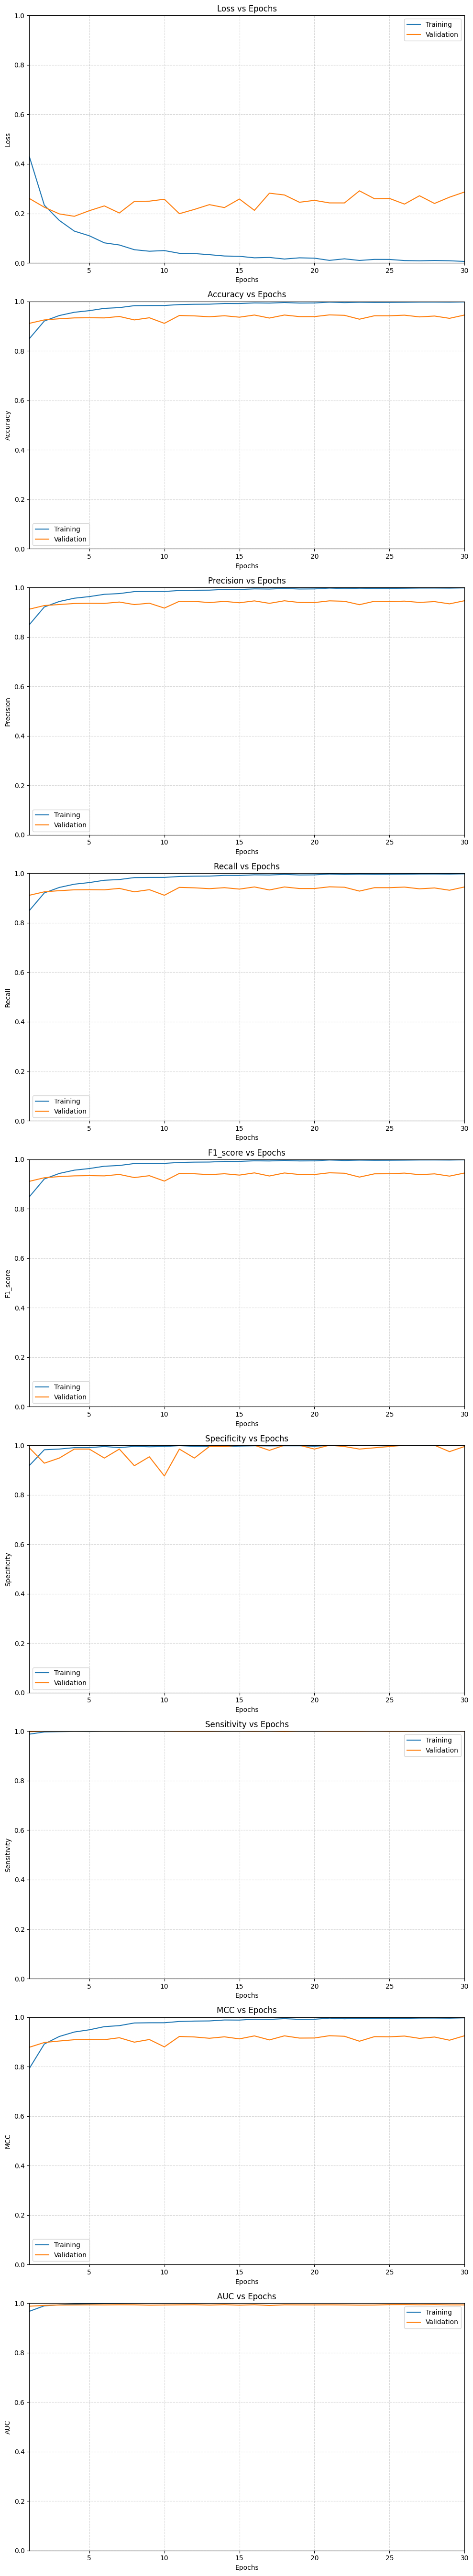

In [16]:
def plot_metrics(train_metrics_history, val_metrics_history, metric_names):
    num_metrics = len(metric_names)
    num_epochs = len(train_metrics_history[metric_names[0]])

    figure, axes = plt.subplots(num_metrics, figsize=(10, 6 * num_metrics))
    rng = range(1, num_epochs + 1)

    for ax, metric_name in zip(axes, metric_names):
        train_metric = train_metrics_history[metric_name]
        val_metric = val_metrics_history[metric_name]

        ax.plot(rng, train_metric, label="Training")
        ax.plot(rng, val_metric, label="Validation")
        ax.legend()
        ax.set_xlabel("Epochs")

        if metric_name in ("auc", "mcc"):
            ax.set_ylabel(metric_name.upper())
            ax.set_title(f"{metric_name.upper()} vs Epochs")
        else:
            ax.set_ylabel(metric_name.capitalize())
            ax.set_title(f"{metric_name.capitalize()} vs Epochs")

        max_metric = max(max(train_metric), max(val_metric))
        min_metric = min(min(train_metric), min(val_metric))
        y_max = math.ceil(max_metric)

        if min_metric > 0 or max_metric > 1:
            ax.set_ylim(0, y_max)
        else:
            ax.set_ylim(min_metric, y_max)

        ax.grid(True, linestyle='--', alpha=0.5)
        # Adjust xlim to avoid identical low and high limits.
        if num_epochs == 1:
            ax.set_xlim(0.5, 1.5)
        else:
            ax.set_xlim(1, num_epochs)

    plt.tight_layout()
    plt.show()

plot_metrics(train_metrics_history, val_metrics_history, metric_names)

In [17]:
# Testing loop
model.eval()
total_test_loss = 0.0
all_test_predictions = []
all_test_targets = []

with torch.no_grad():
    for batch_idx, (data, targets) in enumerate(tqdm(test_loader, desc="Testing Model")):
        data = data.to(device)
        targets = targets.to(device)

        outputs = model(data)
        loss = criterion(outputs, targets)
        total_test_loss += loss.item()

        all_test_predictions.extend(outputs.detach().cpu().numpy())
        all_test_targets.extend(targets.detach().cpu().numpy())

all_test_predictions = np.array(all_test_predictions)
all_test_targets = np.array(all_test_targets)

average_test_loss = total_test_loss / len(test_loader)
test_metrics = custom_metrics(torch.tensor(all_test_predictions), torch.tensor(all_test_targets), average_test_loss)
testing_metrics_line = "Test Metrics - " + ", ".join([f"{k}: {v:.4f}" for k, v in test_metrics.items()])
print(testing_metrics_line)

Testing Model: 100%|██████████| 617/617 [00:14<00:00, 41.25it/s]


Test Metrics - loss: 0.2509, accuracy: 0.9479, precision: 0.9488, recall: 0.9479, f1_score: 0.9475, specificity: 0.9820, sensitivity: 1.0000, mcc: 0.9291, auc: 0.9939


In [18]:
# Convert true_labels and predicted_labels to numpy arrays
true_labels = np.array(all_test_targets)

# Assuming predicted_labels are probabilities, convert them to class labels
predicted_labels = np.argmax(np.array(all_test_predictions), axis=1)

# Ensure both true_labels and predicted_labels are of integer type
true_labels = true_labels.astype(int)
predicted_labels = predicted_labels.astype(int)

# Get a list of subdirectories (class names) in the data directory
# Option 1: sort the list
# classes = sorted([d for d in os.listdir(data_path) if os.path.isdir(os.path.join(data_path, d))])

# # Option 2: if using ImageFolder
classes = full_train_dataset.classes

# classes = label_encoder.classes_

# Generate a classification report
report = classification_report(true_labels, predicted_labels, target_names=classes, digits=4)

# Calculate accuracy
accuracy = accuracy_score(true_labels, predicted_labels)
num_errors = np.sum(true_labels != predicted_labels)

print(report)
print(f'There were {num_errors} errors in {len(predicted_labels)} tests for an accuracy of {accuracy*100:6.2f}')

                     precision    recall  f1-score   support

Bacterial Pneumonia     1.0000    0.9820    0.9909       556
              COVID     0.9620    0.9806    0.9712       723
       Lung_Opacity     0.9604    0.8669    0.9112      1202
             Normal     0.9221    0.9691    0.9450      2039
       Tuberculosis     0.9716    0.9786    0.9751       140
    Viral Pneumonia     0.9458    0.9740    0.9597       269

           accuracy                         0.9479      4929
          macro avg     0.9603    0.9585    0.9589      4929
       weighted avg     0.9488    0.9479    0.9475      4929

There were 257 errors in 4929 tests for an accuracy of  94.79
